<h2> Objective </h2>

 * We need to build a custom tokenizer, if the domain of a dataset is different from the existing datasets on which the tokenizers were trained on .
 * Say, for example, you want to build a model that respond to questions from chemistry domain.
 * Build a Custom tokenizer using the BPE tokenization algorithm
 * Store and load configuration files
 * Encode and decode a batch of sequences


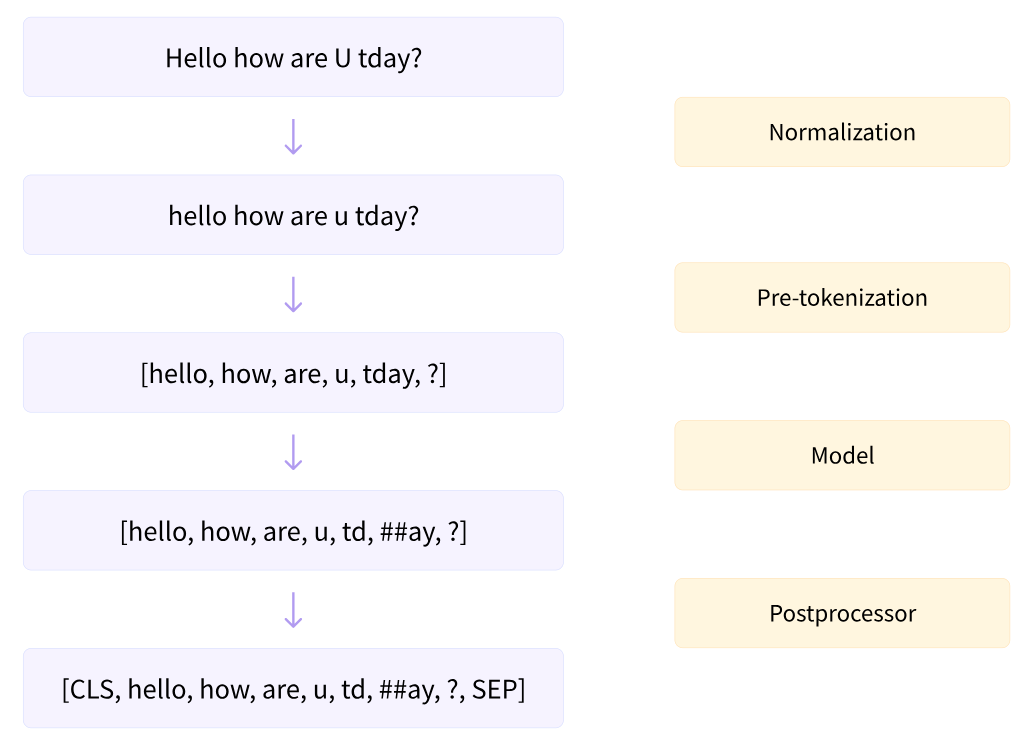

# Tokenization
* At a highlevel, we have three sequential steps
  1. Build a vocabulary from the corpus (training phase)
  2. Encode a **batch** of text sequence with appropriate padding,masking,..
  3. Decode the **batch** text sequence and do postprocessing to make it human readable.

* To build the above pipeline, HF `tokenizers `module provides various submodules/classes such as
 * *tokenizers.Tokenizer* (Base class for all tokenizer)
 * *tokenizers.models*  (module that implements BPE, wordPiece in Rust)
 * *tokenizers.normalizers* (module for normalization algorithms like lowercase)
 * *tokenizers.pre_tokenizers*
 * *tokenizers.trainers*

* Uses rust programming language instead of Python for faster training! Takes **less than 20 seconds** to tokenize a **GB** of text on a server’s CPU.

* Naturally, we expect the **Tokenizer** class to have methods to
  * normalize (lowercase,strip whitespace,remove ascents..), pre-tokenize (say,whitespace)
  * `train() ` using tokenization algorithms like BPE, WordPiece, and build the vocabulary
  * `encode()` the text a sequence and return token ids for the model to process
  * `decode()` the tokens ids and return text sequence
  * save/load  the vocab, merge rules for inference.
  * add/remove special tokens

Reference:
1. https://huggingface.co/docs/tokenizers/quicktour
2. https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt
  

In [ ]:
# [ ]
#  ["b":0, "g":1, "h":2, "n":3, "p":4, "s":5, "u":6, "t":7 "ug":8, "un":9, "hug":10]
# u, g -> ug
# u, n -> un
# h, ug -> hug
#
# thugs
t, h, u, g, s
t, h, ug, s
t, hug, s
[7,10,5]

In [5]:
?BpeTrainer

In [1]:
# enable tab completion
%config IPCompleter.greedy=True

In [2]:
%%capture
#run this cell if you are using colab
!pip install datasets
# !pip install --upgrade huggingface_hub

In [3]:
import os

# Tokenizer specific functionalities
from tokenizers import Tokenizer # tokenizer base class
from tokenizers.models import BPE # tokenization algorithm
from tokenizers.normalizers import Lowercase # simple one
from tokenizers.pre_tokenizers import Whitespace # written in Rust, whitespace.rs
from tokenizers.trainers import BpeTrainer

In [4]:
# # change the working directory if required
# os.chdir('/home/arun/hf-workshop/')

* HF facilitates loading tons of datasets easily from the Hub
* Let's load a dataset for machine translation

## Dataset
* Download a translation dataset
* Since tokenizers use all the samples in the dataset, we need to download the entire dataset without any splits
* However, opus_books has only one split for "en-fr".

In [ ]:
from datasets import load_dataset,get_dataset_split_names
print(get_dataset_split_names("opus_books","en-fr")) # we have only train set for opus

['train']


In [ ]:
books= load_dataset("opus_books", "en-fr", split="train")

In [ ]:
print(books)

Dataset({
    features: ['id', 'translation'],
    num_rows: 127085
})


In [ ]:
books[100:104]

{'id': ['100', '101', '102', '103'],
 'translation': [{'en': 'Then, as long as there was a ray of light, I stopped in the record-room at the town hall, with its dead flies and posters that flapped in the draught, and I read, sitting on an old weighing-machine, close to a window looking on the garden.',
   'fr': 'Alors, tant qu’il y avait une lueur de jour, je restais au fond de la mairie, enfermé dans le cabinet des archives plein de mouches mortes, d’affiches battant au vent, et je lisais assis sur une vieille bascule, auprès d’une fenêtre qui donnait sur le jardin.'},
  {'en': 'When it was quite dark, and the dogs of the neighbouring farm began to howl and a light was seen at the window of our little kitchen, then I went home.',
   'fr': 'Lorsqu’il faisait noir, que les chiens de la ferme voisine commençaient à hurler et que le carreau de notre petite cuisine s’illuminait, je rentrais enfin.'},
  {'en': 'Mother had begun to get supper ready.',
   'fr': 'Ma mère avait commencé de prép

* Note again that the books is a `DatasetDict` class with helpful attributes and methods to work on the samples in the dataset
* Unlike, WMT dataset, the OPUS dataset has two columns: id, translation
* We may remove the extra ID column

In [ ]:
print(books.num_columns) # id, translation
dataset = books.remove_columns('id') # not in place
print(dataset)
print(len(dataset))

2
Dataset({
    features: ['translation'],
    num_rows: 127085
})
127085


* The important class is the `Dataset` class that holds the actual samples and labels. It also acts like a dictionary, however, with a plenty of useful methods (as detailed in the previous notebook)
* Each sample is a dictionary that contains the text in the source and in the target language

In [ ]:
#split the dataset
dataset = dataset.train_test_split(test_size=0.1)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 114376
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 12709
    })
})


In [ ]:
dataset['train'][0:2]

{'translation': [{'en': '"Yes," said Herbert, "and icebergs are met with in lower latitudes in the south than in the north of the Pacific."',
   'fr': '-- En effet, dit Harbert, et les glaces flottantes se rencontrent sous des latitudes plus basses dans le sud que dans le nord du Pacifique.'},
  {'en': '"You have explained, sir; but it is for others in another place to say if that explanation is satisfactory."',
   'fr': "Mais c'est à d'autres et dans un autre lieu qu'ici que vous aurez à prouver que votre explication est satisfaisante."}]}

## Configuring tokenizer
* Let's keep the source vocabulary size as 5000
* Let's build the target tokenizer with the vocab size of 6000

In [ ]:
#initiate the tokenizer with algorithm (BPE,wordpiece,sentpiece), pre-tokenization, normalization
src_tokenizer = Tokenizer(BPE())
src_tokenizer.pre_tokenizer = Whitespace() # whitespace as a word delimiter to keep things easy
src_tokenizer.normalizer = Lowercase()

#train the tokenization algorithm, we do not need BOS token for src
src_trainer = BpeTrainer(vocab_size=5000,
                         special_tokens=["[PAD]","[EOS]","[UNK]"],
                         continuing_subword_prefix='</w>') # order of the special tokens matter!

# same for target language tokenizer
tar_tokenizer = Tokenizer(BPE())
tar_tokenizer.pre_tokenizer = Whitespace() # whitespace as a word delimiter
tar_tokenizer.normalizer=Lowercase()
tar_trainer = BpeTrainer(vocab_size=6000,
                         special_tokens=["[PAD]", "[BOS]","[EOS]","[UNK]"],
                         continuing_subword_prefix='</w>')

In [ ]:
# slosh
# s l o </w>s h

## Building the vocabulary

* We need to build vocabulary for both source and target languages
* We need two tokenizers because transformer encoder is different from the decoder.
* If we use, say, just decoder only, then we could use single tokenizer by concatenating source and target sentences
* A trainer will take care of all these

### Passing all samples
* Collect all sentences (strings) in a list because we can pass only string or list of strings for training the tokenizer
* For now, just considering sentences from training set (not the entire dataset)
* And pass it through an iterator

In [ ]:
# seq of source language
src_train_set = [sample["en"] for sample in dataset['train']['translation']]
# seq of tar language
tar_train_set = [sample["fr"] for sample in dataset['train']['translation']]

In [ ]:
print(f'Number of samples, source:{len(src_train_set)}')
print(f'Number of samples, target:{len(tar_train_set)}')

Number of samples, source:114376
Number of samples, target:114376


In [ ]:
src_tokenizer.train_from_iterator(src_train_set, trainer=src_trainer)

In [ ]:
src_tokenizer.save('src_tokenizer.json')

In [ ]:
!head -n 135 src_tokenizer.json|tail -n 30

      "r": 54,
      "s": 55,
      "t": 56,
      "u": 57,
      "v": 58,
      "w": 59,
      "x": 60,
      "y": 61,
      "z": 62,
      "{": 63,
      "}": 64,
      "~": 65,
      "£": 66,
      "«": 67,
      "°": 68,
      "»": 69,
      "à": 70,
      "â": 71,
      "ã": 72,
      "ä": 73,
      "æ": 74,
      "ç": 75,
      "è": 76,
      "é": 77,
      "ê": 78,
      "ë": 79,
      "î": 80,
      "ï": 81,
      "ô": 82,
      "ö": 83,


* Well, we can view the serialized json content quickly by using ```to_str()``

* Truncation and padding are null as we haven't enabled that
* Each special token is saved as type "[AddedToken](huggingface.co/docs/tokenizers/v0.13.4.rc2/en/api/added-tokens#tokenizers.AddedToken)" instead of raw string.
* The vocab is a dictionary
* All the information about the tokenizer is serialized. So that, given this info, one can construct the tokenizer without the data on which it was trained.

In [ ]:
src_vocab = src_tokenizer.get_vocab()
# print(src_vocab) # uncomment

In [ ]:
# we can reload it
src_tokenizer = Tokenizer.from_file("src_tokenizer.json")

In [ ]:
tar_tokenizer.train_from_iterator(tar_train_set, trainer=tar_trainer)

In [ ]:
tar_tokenizer.save('tar_tokenizer.json')

### Train by passing a batch of samples
* The previous approach takes all the samples before feeding those to tokenizer. It takes a lot of additional memory
* The input to tokenizers should be string. However, each sample in our dataset is a dictionary.
* Therefore, we have to flatten that before feeding it into the trainer.

In [ ]:
def batch_iterator(batch_size=1000,language='source'):
    for i in range(0, len(dataset), batch_size):
        #flatten the dataset
        if language=='source':
            yield dataset['train'].flatten()[i : i + batch_size]['translation.en'] # use all the splits
        else:
            yield dataset['train'].flatten()[i : i + batch_size]['translation.fr']

In [ ]:
src_tokenizer.train_from_iterator(batch_iterator(), trainer=src_trainer, length=len(dataset))

In [ ]:
tar_tokenizer.train_from_iterator(batch_iterator(language='target'), trainer=src_trainer, length=len(dataset))

* If we have stored a dataset in gzip, we can directly use them to train the tokenizer

# Encoding
* Caution: The word Encoding in the context of toeknizer has nothing to do with Encoding in the context of Transformers.

* Encode takes in a text sequence and returns token_ids by applying the following process in order
  * Normalization
  * Pre-Tokenization
  * Trained model (say,BPE)
  * Token_ids
  * Post processing

* [Link](https://huggingface.co/docs/tokenizers/v0.13.4.rc2/en/api/tokenizer#tokenizers.Tokenizer.encode) to documentation

In [ ]:
src_encoded = src_tokenizer.encode(sequence="This is a fun example haha.",
                                   pair=None,
                                   is_pretokenized=False)
print(src_encoded)
print(src_encoded.tokens)
print(src_encoded.attention_mask)

Encoding(num_tokens=10, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['this', 'is', 'a', 'f', '</w>un', 'exam', '</w>ple', 'ha', '</w>ha', '.']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
tar_encoded = tar_tokenizer.encode(sequence="c'est un exemple amusant",
                                   pair=None,
                                   is_pretokenized=False)
print(tar_encoded)
print(tar_encoded.tokens)
print(tar_encoded.attention_mask)

Encoding(num_tokens=8, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['c', "'", 'est', 'un', 'exe', '</w>mple', 'amus', '</w>ant']
[1, 1, 1, 1, 1, 1, 1, 1]


* Note the output type is ```Encoding``` which has some useful methods to manipulate the output

In [ ]:
from tokenizers import Encoding
merged = Encoding.merge([src_encoded,tar_encoded])
print(merged)
print(merged.tokens)

Encoding(num_tokens=18, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['this', 'is', 'a', 'f', '</w>un', 'exam', '</w>ple', 'ha', '</w>ha', '.', 'c', "'", 'est', 'un', 'exe', '</w>mple', 'amus', '</w>ant']


* What if we want to append [PAD] to the sequence?
* For a batch of sequence, encode_batch() function does this automatically.
* Let's pad the input sequence a bit differently
* Well, we can do that

In [ ]:
src_encoded.pad(length=15)
print(src_encoded.tokens)

['this', 'is', 'a', 'f', '</w>un', 'exam', '</w>ple', 'ha', '</w>ha', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


* Note that the output returned by the tokenizer is "Encoding" with attributes set internally
* Right now, we expect the model to attend to all tokens! (we can't overwrite it)
* Note also that the word "This" was normalized to "this"
* However, you should be mindful if you explicitly call `token_to_id` method (thought you never need to do that)

In [ ]:
#passing a pair
src_encoded_pair = src_tokenizer.encode(sequence="This is a fun example haha.",
                                        pair="pairing is not difficult") # just two sequences
print(src_encoded_pair)
print(src_encoded_pair.tokens)
print(src_encoded_pair.attention_mask)
print(src_encoded_pair.type_ids) # applicable to BERT like model

Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['this', 'is', 'a', 'f', '</w>un', 'exam', '</w>ple', 'ha', '</w>ha', '.', 'pa', '</w>ir', '</w>ing', 'is', 'not', 'difficult']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [ ]:
from tokenizers.tools import EncodingVisualizer
visualizer = EncodingVisualizer(tokenizer=src_tokenizer)
visualizer(text="This is a fun example biblical.")

In [ ]:
print([src_tokenizer.token_to_id(token) for token in ["[EOS]","ha","h", 'a','ex']])

[1, 163, 36, 29, 254]


* Normalization is applied before pre-tokenization.
* Therefore, internally the text sequence is normalized and then `token_to_id` method is called.

* We need to convert the raw text sequence to model specific format by appending special tokens such [BOS] and [EOS].
* The format (template) changes based of the model
* Well, HF `tokenizer.processors` module ease that by providing various post processing templates
* Now, we want to prepend [BOS] to every **target** sequence and append [EOS] tokens to every **source and target** sequence.


In [ ]:
tar_tokenizer.token_to_id("[BOS]")

1

In [ ]:
from tokenizers.processors import TemplateProcessing
# for source
src_tokenizer.post_processor = TemplateProcessing(single="$A [EOS]",
                                                  special_tokens=[("[EOS]",src_tokenizer.token_to_id("[EOS]"))]
                                                  )

#for target
tar_tokenizer.post_processor = TemplateProcessing(single="[BOS] $A [EOS]",
                                                  special_tokens=[("[BOS]",tar_tokenizer.token_to_id("[BOS]")),
                                                                  ("[EOS]",tar_tokenizer.token_to_id("[EOS]"))                                                                    ]
                                                  )



* Well, we always pass a batch of sequences
* It returns **not only just** tokens for each sequence but also the type_ids, attention_mask, special_tokens_mask

# Padding
* The last thing we need to do (for batching) is to pad the shorter sentences with pad tokens
* Though we added '[PAD]' token in the vocabulary, we just need to enable that
* The '[PAD]' token will be ignored while computing attention

In [ ]:
src_tokenizer.enable_padding(pad_id=src_tokenizer.token_to_id('[PAD]'),pad_token="[PAD]") # defaults to right direction
tar_tokenizer.enable_padding(pad_id=tar_tokenizer.token_to_id('[PAD]'),pad_token="[PAD]") # defaults to right direction

* Now, we need to save the updated tokenizer (of course, we can discord the previously saved JSON files)

In [ ]:
#see the details of padding
print(src_tokenizer.padding)
# all these attributes can also be set internally via config file and passing them as **kwargs

{'length': None, 'pad_to_multiple_of': None, 'pad_id': 0, 'pad_token': '[PAD]', 'pad_type_id': 0, 'direction': 'right'}


In [ ]:
src_tokenizer.save('src_tokenizer.json')
tar_tokenizer.save('tar_tokenizer.json')

## Batchify

 * ```.encode_batch()``` takes in List of **strings** and outputs List of **Enocodings**

In [ ]:
# pass in a LIST of seq and get a LIST of encodings for each sample
batch = src_tokenizer.encode_batch(input=["HF is great.",
                                          "One can build a complicated system quickly"]) # List[strs]
print(batch) # output type: List[Encoding]
print(batch[0].type_ids)
print(batch[0].tokens)
print(batch[1].tokens)
print(len(batch[0].tokens))
print(len(batch[1].tokens))
# print(batch.special_token_mask)

[Encoding(num_tokens=11, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=11, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['h', '</w>f', 'is', 'great', '.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['one', 'can', 'build', 'a', 'comp', '</w>lic', '</w>ated', 'sy', '</w>stem', 'quickly', '[EOS]']
11
11


* We can extend the same concept to a ```list of pair(tuple) of sequences```

In [ ]:
# pass in a LIST of seq and get a LIST of encodings for each sample
batch = src_tokenizer.encode_batch([("HF is great","One can build a complicated system quickly"),("sentence one here","i am sentence two")])
print(batch)
print(batch[0].type_ids)
print(batch[0].tokens)
print(batch[0].attention_mask)
# print(batch.special_token_mask)

[Encoding(num_tokens=14, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=14, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['h', '</w>f', 'is', 'great', 'one', 'can', 'build', 'a', 'comp', '</w>lic', '</w>ated', 'sy', '</w>stem', 'quickly']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


* There are many ways of batching samples to efficiently utilize the compute operations
     * Uniform Batching (waste of compute)
     * Dynamic batching (HF Follows this)
     * Using Nested Tensors (only supported in pytorch, still in its beta stage)

In [ ]:
batch_padded_src = src_tokenizer.encode_batch(["Photosynthesis is a biological process","that is a  cool idea"])
# print(batch_padded_src)
print(batch_padded_src[0].tokens)# for first sentence
print(batch_padded_src[0].attention_mask)
print(batch_padded_src[0].offsets)
print(batch_padded_src[1].tokens)# for first sentence
print(batch_padded_src[1].attention_mask)
print(batch_padded_src[1].offsets)

['ph', '</w>ot', '</w>os', '</w>y', '</w>n', '</w>th', '</w>es', '</w>is', 'is', 'a', 'b', '</w>io', '</w>log', '</w>ical', 'process', '[EOS]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[(0, 2), (2, 4), (4, 6), (6, 7), (7, 8), (8, 10), (10, 12), (12, 14), (15, 17), (18, 19), (20, 21), (21, 23), (23, 26), (26, 30), (31, 38), (0, 0)]
['that', 'is', 'a', 'c', '</w>ool', 'idea', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[(0, 4), (5, 7), (8, 9), (11, 12), (12, 15), (16, 20), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


In [ ]:
batch_padded_src = src_tokenizer.encode_batch(["pug hug mug"])
# print(batch_padded_src)
print(batch_padded_src[0].tokens)# for first sentence
print(batch_padded_src[0].attention_mask)
print(batch_padded_src[0].offsets)
# print(batch_padded_src[1].tokens)# for first sentence
# print(batch_padded_src[1].attention_mask)
# print(batch_padded_src[1].offsets)

['pu', '</w>g', 'h', '</w>ug', 'mu', '</w>g', '[EOS]']
[1, 1, 1, 1, 1, 1, 1]
[(0, 2), (2, 3), (4, 5), (5, 7), (8, 10), (10, 11), (0, 0)]


* 1 in attention mask denotes the token at that position is to be attended
* 0 denotes, those tokens not to be attended.

In [ ]:
batch_padded_tar = tar_tokenizer.encode_batch(["La photosynthèse est un processus biologique","c'est une bonne idée"])
print(batch_padded_tar)
print(batch_padded_tar[1].tokens)# for first sentence
print(batch_padded_tar[1].attention_mask)

[Encoding(num_tokens=19, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=19, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]
['[BOS]', 'c', "'", 'est', 'une', 'bonne', 'idée', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# from tokenizers import Encoding
# merged = Encoding.merge([batch_padded_src,batch_padded_tar])
# print(merged.tokens)

# Decoding

 * Decoder takes in token_ids and return the text sequence
 * It also removes the special tokens
 * However, naive BPE algorithm does not use any special symbols to denote the subtokens

In [ ]:
from tokenizers.decoders import WordPiece

In [ ]:
batch_padded_src[0].tokens

['pu', '</w>g', 'h', '</w>ug', 'mu', '</w>g', '[EOS]']

In [ ]:
# pu > ug
# mu > ug
# ug > hu

In [ ]:
pred_token_ids = [encoded.ids for encoded in batch_padded_src]
print(pred_token_ids)
src_tokenizer.decode_batch(pred_token_ids)

[[2116, 92, 36, 2147, 597, 92, 1]]


['pug hug mug']

In [ ]:
# batch_padded_src

* Well, this is not the output we want. we can use BERT tokenizer which inserts special symbols to denote the subtokens while encoding the sequence
* While decoding we can set the `src_tokenizer.decoder=WordPiece()` which retrieves the original sequence as is.

In [ ]:
pred_token_ids = [encoded.ids for encoded in batch_padded_src]
print(pred_token_ids)
src_tokenizer.decoder = WordPiece(prefix='</w>')
src_tokenizer.decode_batch(pred_token_ids)

[[2116, 92, 36, 2147, 597, 92, 1]]


['pug hug mug']

In [ ]:
src_tokenizer.decode_batch(pred_token_ids)

['pug hug mug']

Anyhow, in translation task, we care about the output of target sequence

# Boilerplate code

 * All that it takes now is just a few line of code to build the cutomized tokenizer!
 * The data that we pass to the model should be an iterator (as in the case of torchtext).
 * Therefore, it could be a `list, tuple, or custom class` with iterator method with the only condition that the iterator should return `str`

In [ ]:
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, trainers
tokenizer = Tokenizer(models.Unigram())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoder = decoders.ByteLevel()
trainer = trainers.UnigramTrainer(
    vocab_size=20000,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    special_tokens=["<PAD>", "<BOS>", "<EOS>"],
)
tokenizer.train_from_iterator(src_train_set, trainer=trainer)

# Wrap PreTrainedTokenizer

 * Now we can use ```PreTrainedTokenizerFast``` from **transformer** library to wrap the tokenizer we have built
 * Then we can pass a batch of samples directly.
 * Internally, it calls all the methods (encode,encode_batch) to constrcut the output.
 * [Link](https://huggingface.co/docs/transformers/v4.41.3/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast) to documentation
 * Here I call this ```src_wrapped_tokenizer```, when we use it directly while training, we simply call it a ```toeknizer```

In [ ]:
from transformers import PreTrainedTokenizerFast

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
#for source
src_wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="src_tokenizer.json",
    bos_token = None,
    eos_token = "[EOS]",
    unk_token = "[UNK]",
    pad_token = "[PAD]",
    model_input_names = ["input_ids","attention_mask"] # we just need these two fields to be passed to the model
    )

# target
tar_wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="tar_tokenizer.json",
    bos_token = "[BOS]",
    eos_token = "[EOS]",
    unk_token = "[UNK]",
    pad_token = "[PAD]",
    model_input_names = ["input_ids","attention_mask"] # a few more ids: type_ids, special_token_mask

    )

In [ ]:
import pprint
input_batch_src = src_wrapped_tokenizer(["HF is great","One can build a complicated system quickly"],padding=True,return_tensors='pt')
pprint.pprint(input_batch_src)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  36,   82,  223,  427,    1,    0,    0,    0,    0,    0,    0],
        [ 276,  425, 3483,   29,  965, 1381,  434, 1488, 4978, 3741,    1]])}


In [ ]:
input_batch_tar = tar_wrapped_tokenizer(["L'HF est géniale","On peut construire rapidement un système compliqué"],padding=True,return_tensors='pt')
pprint.pprint(input_batch_src)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  36,   82,  223,  427,    1,    0,    0,    0,    0,    0,    0],
        [ 276,  425, 3483,   29,  965, 1381,  434, 1488, 4978, 3741,    1]])}


* What if I want to train a tokenizer on (not completely) new data that might contain some words not in the vocabulary?

In [ ]:
#src_wrapped_tokenizer.train_new_from_iterator

### Note:

 * Here we used separate tokenizers to build a vocabulary for source and target languages.
 * The other possibility is to use a shared vocabulary for both source and target.
 * Take that as an exercise. We will use a shared vocabulary for training a model in the next notebook
 * How many special tokens are there?

  * It depends on the model we use. BOS,EOS,SEP and PAD are commonly used special tokens.

  * For [Galactica model](https://arxiv.org/abs/2211.09085) we have more special tokens like [START_REF] and [END_REF] to denote start and end of reference paper, [IMAGE] to denote an Image removed from text and many more.

  * It is usally a thing when your dataset comprises of different modalities such as code, chemistry, maths,...